In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, KFold

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer

# EDA

In [2]:
#Read the dataset
df = pd.read_csv('df.csv')

In [3]:
# Display basic information about the df set
print("Basic Information:")
print(df .info())

Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226486 entries, 0 to 226485
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      226486 non-null  int64  
 1   date            226486 non-null  object 
 2   category_id     226486 non-null  int64  
 3   sku_id          226486 non-null  int64  
 4   sales_price     226486 non-null  float64
 5   sales_quantity  226486 non-null  float64
dtypes: float64(2), int64(3), object(1)
memory usage: 10.4+ MB
None


In [4]:
# Display the first few rows of the dataset
print("\nFirst few rows:")
print(df.head())


First few rows:
   Unnamed: 0        date  category_id  sku_id  sales_price  sales_quantity
0       78161  2016-11-25            7    1108       457.60             1.0
1       81079  2016-11-18            7    2999       470.60             1.0
2       81177  2016-11-18            7    1428       717.60             1.0
3       81292  2016-11-18            7    3923       383.50             1.0
4       81416  2016-11-18           17    8075        18.85             2.0


In [5]:
# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())


Missing values in each column:
Unnamed: 0        0
date              0
category_id       0
sku_id            0
sales_price       0
sales_quantity    0
dtype: int64


* Remove the Unnamed: 0 column because it is not needed.

In [6]:
#Deleting column 'Unnamed' - this data is not nessesary
df = df.drop(columns=['Unnamed: 0'])

df

,date,category_id,sku_id,sales_price,sales_quantity
0,2016-11-25,7,1108,457.60,1.0
1,2016-11-18,7,2999,470.60,1.0
2,2016-11-18,7,1428,717.60,1.0
3,2016-11-18,7,3923,383.50,1.0
4,2016-11-18,17,8075,18.85,2.0
...,...,...,...,...,...
226481,2020-10-14,7,21442,570.70,1.0
226482,2020-10-14,7,502340,505.70,3.0
226483,2020-10-14,7,723588,401.70,3.0
226484,2020-10-17,7,792124,778.70,1.0


In [7]:
df.describe()
#we don't have negative values in sales_price and sales_quantity columns

,category_id,sku_id,sales_price,sales_quantity
count,226486.000000,226486.000000,226486.000000,226486.000000
mean,15.069594,497813.898607,109.033102,16.078857
std,4.625731,242446.818578,151.500911,184.248121
min,7.000000,1045.000000,1.027000,1.000000
25%,17.000000,398064.000000,38.220000,1.000000
50%,17.000000,550996.000000,51.350000,3.000000
75%,17.000000,702116.000000,71.500000,5.000000
max,23.000000,838924.000000,2923.700000,8069.000000


In [8]:
#check if the category_id is balanced
category_id_counts = df['category_id'].value_counts()
category_id_counts

category_id
17    160797
7      51959
23     13730
Name: count, dtype: int64

* Let's convert the date column to a date format.

In [9]:
#Transforming column 'date' on datetime format
df['date'] = pd.to_datetime(df['date'])
#checking output after converting
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226486 entries, 0 to 226485
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   date            226486 non-null  datetime64[ns]
 1   category_id     226486 non-null  int64         
 2   sku_id          226486 non-null  int64         
 3   sales_price     226486 non-null  float64       
 4   sales_quantity  226486 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 8.6 MB


(None,
         date  category_id  sku_id  sales_price  sales_quantity
 0 2016-11-25            7    1108       457.60             1.0
 1 2016-11-18            7    2999       470.60             1.0
 2 2016-11-18            7    1428       717.60             1.0
 3 2016-11-18            7    3923       383.50             1.0
 4 2016-11-18           17    8075        18.85             2.0)

### Let's do some deeper analysis:
* Distribution of sales by day 
* Distribution of sales by category 
* Distribution of sales by product. We will use SKU
* Analysis of price median

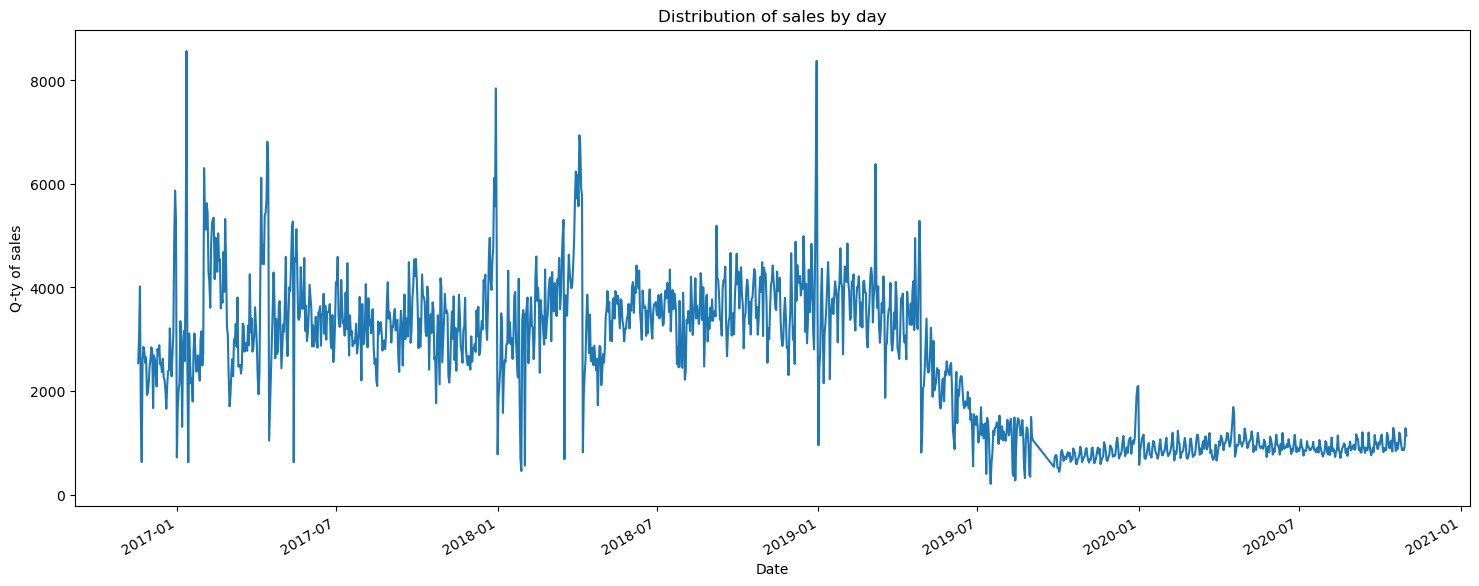

In [10]:
#Distribution of sales by day
plt.figure(figsize=(18, 7))
df.groupby('date')['sales_quantity'].sum().plot(title='Distribution of sales by day')
plt.xlabel('Date')
plt.ylabel('Q-ty of sales')
plt.show()

* Distribution of sales by day: Visualization shows that the number of sales has a significant variability, which may be due to seasonality or other factors. Also , we have a significant drop in sales_quantity

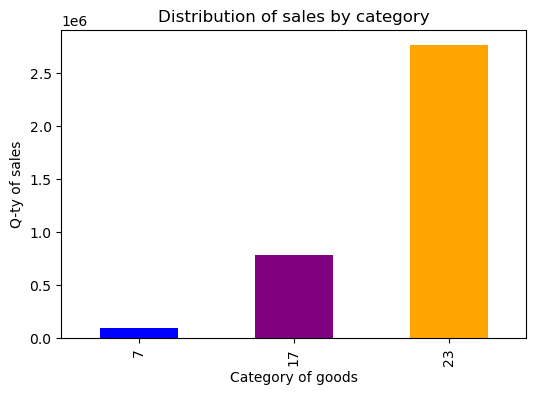

In [11]:
#Distribution of sales by category 
plt.figure(figsize=(6, 4))
colors = ['blue', 'purple', 'orange']
df.groupby('category_id')['sales_quantity'].sum().plot(kind='bar', color=colors, title='Distribution of sales by category')
plt.xlabel('Category of goods')
plt.ylabel('Q-ty of sales')
plt.show()

* Distribution of sales by category: Visualization shows that the category "23" has a significant q-ty compared to "7" and "17"

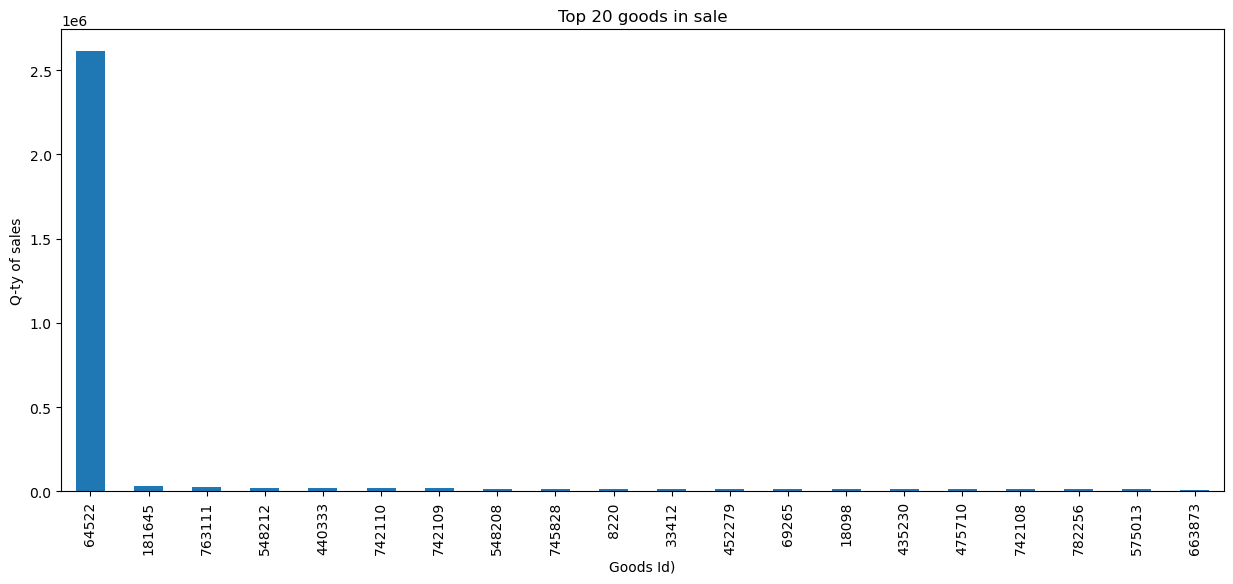

In [12]:
# Distribution of sales by product. We will use SKU.
plt.figure(figsize=(15, 6))
top_sku_sales = df.groupby('sku_id')['sales_quantity'].sum().sort_values(ascending=False).head(20)
top_sku_sales.plot(kind='bar', title='Top 20 goods in sale')
plt.xlabel('Goods Id)')
plt.ylabel('Q-ty of sales')
plt.show()

* Distribution of sales by product: SKUs_id 64522 has the highest q-ty of sales

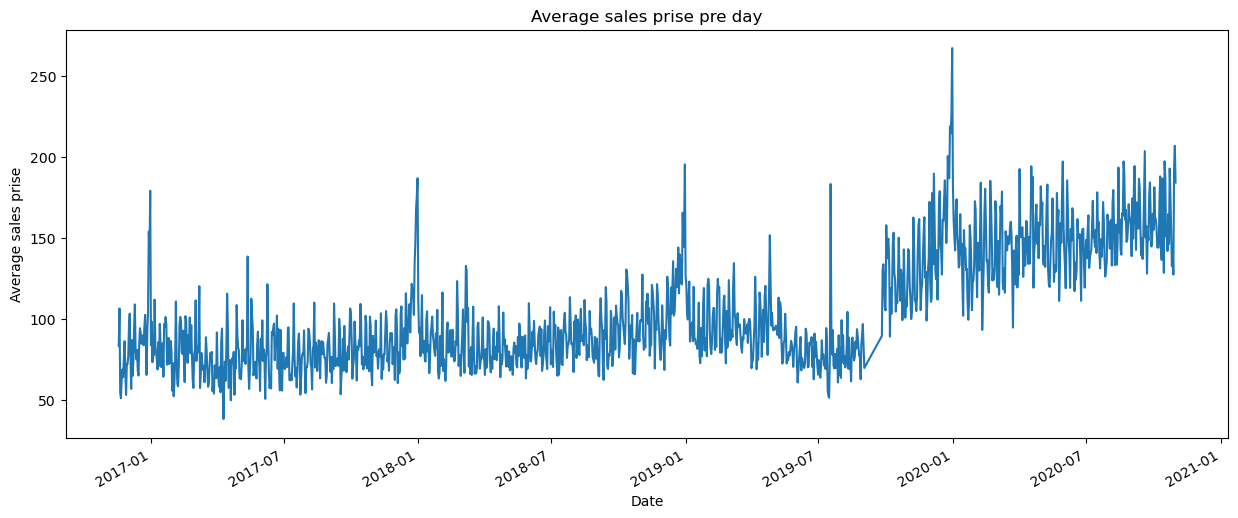

In [13]:
#Analysis of price median
plt.figure(figsize=(15, 6))
df.groupby('date')['sales_price'].mean().plot(title='Average sales prise pre day')
plt.xlabel('Date')
plt.ylabel('Average sales prise')
plt.show()

* Average sale price per day: We can notice some growing of sales from 01-2020

#### Look like after the growing in sales price from 01-2020 we have a significant sales drop in q-ty

# Feature engineering

In [14]:
#Create day indicators for week, month, year, day and day off
df['day_of_week'] = df['date'].dt.dayofweek
#Days Indicator (0 - weekday, 1 - day off)
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
df['day_of_month'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['week_of_year'] = df['date'].dt.isocalendar().week
df['year'] = df['date'].dt.year

In [15]:
#Sort df by 'date'
df = df.sort_values(by='date')

#check
df.head()

,date,category_id,sku_id,sales_price,sales_quantity,day_of_week,is_weekend,day_of_month,month,week_of_year,year
2355,2016-11-18,17,415510,23.205,1.0,4,0,18,11,46,2016
2356,2016-11-18,17,420009,22.490,2.0,4,0,18,11,46,2016
8144,2016-11-18,17,567734,23.205,1.0,4,0,18,11,46,2016
8023,2016-11-18,17,556333,32.760,2.0,4,0,18,11,46,2016
7797,2016-11-18,7,566241,283.400,1.0,4,0,18,11,46,2016


# Modeling the data

In [16]:
#Encoding the data using the On-Hot Encoding for categorical variables
encoder = OneHotEncoder(sparse_output=False) #sparse=False, output data in the form of a normal dense NumPy array
encoded_features = encoder.fit_transform(df[['category_id']])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['category_id']))
df_encoded = pd.concat([df.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)
df_encoded = df_encoded.drop(columns=['category_id'])

In [17]:
df_encoded.head()

,date,sku_id,sales_price,sales_quantity,day_of_week,is_weekend,day_of_month,month,week_of_year,year,category_id_7,category_id_17,category_id_23
0,2016-11-18,415510,23.205,1.0,4,0,18,11,46,2016,0.0,1.0,0.0
1,2016-11-18,420009,22.490,2.0,4,0,18,11,46,2016,0.0,1.0,0.0
2,2016-11-18,567734,23.205,1.0,4,0,18,11,46,2016,0.0,1.0,0.0
3,2016-11-18,556333,32.760,2.0,4,0,18,11,46,2016,0.0,1.0,0.0
4,2016-11-18,566241,283.400,1.0,4,0,18,11,46,2016,1.0,0.0,0.0


In [18]:
# Separate numerical features
numerical_features = df_encoded[['sales_price']]
scaler = StandardScaler()
numerical_features_scaled = scaler.fit_transform(numerical_features)

In [19]:
# Combine scaled numerical features with encoded categorical features
df_encoded_scaled = pd.concat([df_encoded.reset_index(drop=True).drop(columns=['sales_price']), 
                               pd.DataFrame(numerical_features_scaled, columns=['sales_price'])], axis=1)

In [20]:
# Features and target variable
X = df_encoded_scaled.drop(columns=['sales_quantity', 'date', 'sku_id'])
y = df_encoded['sales_quantity']

In [21]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
#Set up k-cross validation
kf = KFold(n_splits=8, shuffle=True, random_state=42)

In [25]:
#Creating pipeline for each of the model
models = [
    ('Linear Regression', LinearRegression()),
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('XGBoost', XGBRegressor(random_state=42))
]

In [29]:
#Evaluating using k-cross validation
for name, model in models:
    cv_mae, cv_mse, cv_rmse, cv_r2 = [], [], [], []
    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
        
        # Train the model
        model.fit(X_train_fold, y_train_fold)
        
        # Predict on validation data set
        y_pred = model.predict(X_val_fold)
        
        # Metrics
        cv_mae.append(mean_absolute_error(y_val_fold, y_pred))
        cv_mse.append(mean_squared_error(y_val_fold, y_pred))
        cv_rmse.append(np.sqrt(mean_squared_error(y_val_fold, y_pred)))
        cv_r2.append(r2_score(y_val_fold, y_pred))
    
    print(f"{name}: mae={np.mean(cv_mae)}, mse={np.mean(cv_mse)}, rmse={np.mean(cv_rmse)}, r2={np.mean(cv_r2)}")

Linear Regression: mae=29.64214221857888, mse=32983.220100459235, rmse=181.42475140634224, r2=0.06825396977245544
Random Forest: mae=4.97165579476782, mse=1860.0000291273484, rmse=42.5115085774398, r2=0.9477685014644326
XGBoost: mae=5.2468433021209275, mse=2159.404796994724, rmse=46.15834520529502, r2=0.9391167684051452


* Linear regression is not a good choice for this dataset.
* Random Forest and XGBoost performed significantly better, with similar performance metrics, making them good candidates for selecting hyperparametrs.

In [30]:
#Creating pipelines
pipeline = Pipeline([
    ('regressor', RandomForestRegressor(random_state=42))
])
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

In [46]:
#Set up RandomGridSearchCV
random_grid_search = RandomizedSearchCV(pipeline, param_grid, cv=5, verbose=2, n_jobs=-1, scoring='neg_mean_squared_error')

In [47]:
#fit
random_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('regressor',
                                              RandomForestRegressor(random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'regressor__max_depth': [None, 10, 20,
                                                                 30],
                                        'regressor__min_samples_leaf': [1, 2,
                                                                        4],
                                        'regressor__min_samples_split': [2, 5,
                                                                         10],
                                        'regressor__n_estimators': [100, 200,
                                                                    300]},
                   scoring='neg_mean_squared_error', verbose=2)

In [50]:
#Best hyperparametes and evaluating on test data set
print("Best hyperparametes:", random_grid_search.best_params_)
best_model = random_grid_search.best_estimator_

y_pred = best_model.predict(X_test)
print("Test MAE:", mean_absolute_error(y_test, y_pred))
print("Test MSE:", mean_squared_error(y_test, y_pred))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Test R2:", r2_score(y_test, y_pred))

Best hyperparametes: {'regressor__n_estimators': 300, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 2, 'regressor__max_depth': 20}
Test MAE: 4.426245324844486
Test MSE: 1400.003399851576
Test RMSE: 37.41661930013956
Test R2: 0.950119356930329


### Output the best hyperparemetes for our model: {'regressor__n_estimators': 300, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 2, 'regressor__max_depth': 20}
* Test MAE: 4.426245324844486
* Test MSE: 1400.003399851576
* Test RMSE: 37.41661930013956
* Test R2: 0.950119356930329

In [49]:
#Creating a model with the best hyperparemetes
best_rf_model = RandomForestRegressor(
    max_depth=20,
    min_samples_leaf=2,
    min_samples_split=2,
    n_estimators=300,
    random_state=42
)

In [55]:
# Create DataFrame for Random Forest predictions
best_rf_model = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

In [56]:
# Create Plotly figure for Random Forest
fig_rf = px.scatter(best_rf_model, x='Actual', y='Predicted', title='Random Forest: Actual vs Predicted')
fig_rf.add_shape(type='line', x0=best_rf_model['Actual'].min(), y0=best_rf_model['Actual'].min(), x1=best_rf_model['Actual'].max(), y1=best_rf_model['Actual'].max(), line=dict(dash='dash'))
# Display the figure
fig_rf.show()

In [59]:
# Generate predictions for the next 14 days for each category
category_ids = df['category_id'].unique()
future_dates = pd.date_range(start=df['date'].max() + pd.Timedelta(days=1), periods=14)
future_predictions = {}

for category_id in category_ids:
    future_data = pd.DataFrame({'date': future_dates})
    
    # Add time-based features
    future_data['day_of_week'] = future_data['date'].dt.dayofweek
    future_data['is_weekend'] = future_data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
    future_data['day_of_month'] = future_data['date'].dt.day
    future_data['month'] = future_data['date'].dt.month
    future_data['week_of_year'] = future_data['date'].dt.isocalendar().week
    future_data['year'] = future_data['date'].dt.year
    
    # Encode the category_id
    future_data_encoded = encoder.transform([[category_id]] * 14)
    future_data_encoded_df = pd.DataFrame(future_data_encoded, columns=encoder.get_feature_names_out(['category_id']))
    
    # Combine features
    future_data = pd.concat([future_data.reset_index(drop=True), future_data_encoded_df.reset_index(drop=True)], axis=1)
    
    # Scale numerical features
    future_data['sales_price'] = scaler.transform([[df['sales_price'].mean()]] * 14)
    
    # Drop unnecessary columns
    future_data = future_data.drop(columns=['date'])
    
    # Predict future sales
    future_sales_predictions = best_rf_model.predict(future_data)
    future_predictions[category_id] = future_sales_predictions

future_predictions

c:\Users\uazhyhalbo\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning:

X does not have valid feature names, but OneHotEncoder was fitted with feature names

c:\Users\uazhyhalbo\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



AttributeError: 'DataFrame' object has no attribute 'predict'